In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.8.0
Keras Version: 2.8.0

Python 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
Pandas 1.4.1
Scikit-Learn 1.0.2
GPU is available


In [2]:
from __future__ import print_function, division
from builtins import range

In [3]:
import os
import sys

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text     import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers                 import Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPool1D, Embedding
from tensorflow.keras.models                 import Model
from sklearn.metrics                         import roc_auc_score

In [4]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE      = 20000
EMBEDDING_DIM       = 100
VALIDATION_SPLIT    = 0.2
BATCH_SIZE          = 128
EPOCHS              = 10

In [5]:
print('Loading word vectors....')
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    for line in f:
        values         = line.split()
        word           = values[0]
        vec            = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

print(f'Found {len(word2vec)} word vectors')

Loading word vectors....
Found 400000 word vectors


In [6]:
train           = pd.read_csv("jigsaw-toxic-comment-classification/train.csv")
sentences       = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
targets         = train[possible_labels].values

print(f"max sequence length: {max(len(s) for s in sentences)}")
print(f"min sequence length: {min(len(s) for s in sentences)}")

s = sorted(len(s) for s in sentences)
print(f"median sequence length: {s[len(s)//2]}")

max sequence length: 5000
min sequence length: 6
median sequence length: 205


In [7]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [8]:
word2idx = tokenizer.word_index
print(f"Found {len(word2idx)} unique tokens.")

Found 210337 unique tokens.


In [9]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(f"Shape of data tensor: {data.shape}")

Shape of data tensor: (159571, 100)


In [10]:
print("Filling pre-trained embeddings...")
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [11]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights      = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable    = False
)

In [12]:
print("Building Model....")
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building Model....
Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-03-27 18:02:15.738804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-27 18:02:15.738936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
model = Model(input_, output)
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [14]:
print("Training model.....")
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT
)

Training model.....
Epoch 1/10


2022-03-27 18:02:15.905061: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-27 18:02:16.189621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


998/998 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9702

2022-03-27 18:02:29.305729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


998/998 [==============================] - 15s 14ms/step - loss: 0.0840 - accuracy: 0.9702 - val_loss: 0.0707 - val_accuracy: 0.9664
Epoch 2/10
998/998 [==============================] - 15s 15ms/step - loss: 0.0682 - accuracy: 0.9760 - val_loss: 0.0741 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 15s 15ms/step - loss: 0.0631 - accuracy: 0.9699 - val_loss: 0.0833 - val_accuracy: 0.9843
Epoch 4/10
998/998 [==============================] - 15s 15ms/step - loss: 0.0592 - accuracy: 0.9735 - val_loss: 0.0656 - val_accuracy: 0.9854
Epoch 5/10
998/998 [==============================] - 15s 15ms/step - loss: 0.0561 - accuracy: 0.9760 - val_loss: 0.0690 - val_accuracy: 0.9892
Epoch 6/10
998/998 [==============================] - 15s 15ms/step - loss: 0.0532 - accuracy: 0.9730 - val_loss: 0.0716 - val_accuracy: 0.8499
Epoch 7/10
998/998 [==============================] - 15s 15ms/step - loss: 0.0507 - accuracy: 0.9686 - val_loss: 0.0709 - val_accuracy: 0.9350
Epo

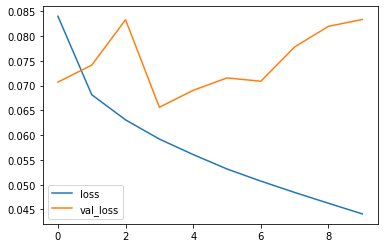

In [22]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig('loss_chart.png')
plt.show()

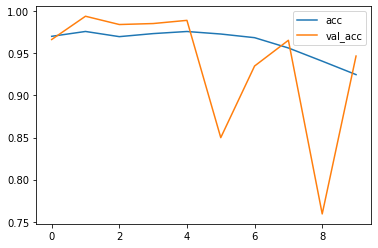

In [23]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig('acc_chart.png')
plt.show()

In [17]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)

print(np.mean(aucs))

2022-03-27 18:04:45.434510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.97839828851849
